In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import zero_one_loss
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import r2_score

# ML algs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Data preparation
We plan to predict the user type (subscriber or customer) and the duration of trip using a few given features.

In [2]:
dat = pd.read_csv('../data.csv', parse_dates=['starttime', 'stoptime']).rename(columns={
    'start.station.latitude': 'lat',
    'start.station.longitude': 'lon'
    })

# define day of week, hour of day, and day-time of week for the starting time
dat['wday'] = dat['starttime'].dt.dayofweek
dat['hour'] = dat['starttime'].dt.hour
dat['wdaytime'] = dat['wday'] + dat['hour']/24.0

# duration of trip: convert seconds to minutes
dat['trip_dur'] = dat['tripduration']/60.0

# predictors: lat, lon, wday, and hour
# labels: usertype (class) and trip_dur (numeric)
dat = dat[['lat', 'lon', 'wday', 'hour', 'usertype', 'trip_dur']]
dat.head()

,lat,lon,wday,hour,usertype,trip_dur
0,40.736245,-73.984738,1,20,Subscriber,5.216667
1,40.730477,-73.999061,4,8,Subscriber,6.116667
2,40.735354,-74.004831,4,8,Subscriber,15.950000
3,40.760193,-73.991255,3,22,Subscriber,15.450000
4,40.711464,-74.005524,6,7,Subscriber,11.583333


In [3]:
# predictors
X = dat[['lat', 'lon', 'wday', 'hour']]

# label for classification
Y = dat['usertype']
print('Class counts for usertype:\n{}'.format(Y.value_counts(dropna=False)))

# label for regression
Z = dat['trip_dur']
print('\nDistribution of trip_dur:\n{}'.format(Z.describe()))

Class counts for usertype:
usertype
Subscriber    43781
Customer       6219
Name: count, dtype: int64

Distribution of trip_dur:
count    50000.000000
mean        14.311048
std         14.348527
min          1.000000
25%          6.800000
50%         10.816667
75%         17.833333
max        346.200000
Name: trip_dur, dtype: float64


# Train classifier to predict usertype

## Create and train model

In [4]:
# split training and test data to predict Y (usertype)
Xy_train, Xy_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=1)

# normalize data for Y
scaler_y = StandardScaler()
scaler_y.fit(Xy_train)
Xy_train_scaled = scaler_y.transform(Xy_train)
Xy_test_scaled = scaler_y.transform(Xy_test)

# create model
model_y = RandomForestClassifier(
    max_depth=3,
    max_samples=0.5,
    random_state=0,
    # there are far more subscribers than customers, so without balancing the classes,
    # the model will simply predict every case as subscriber and gets >85% accuracy
    class_weight='balanced'
)

# train model
model_y.fit(Xy_train_scaled, Y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, max_samples=0.5,
                       random_state=0)

## Inspect model

In [5]:
# score trained model with cross validation
model_y_cv_scores = cross_val_score(model_y, Xy_train_scaled, Y_train, cv=3)

# mean and deviation of accuracy in cv
print('CV accuracy {} +/- {}'.format(np.mean(model_y_cv_scores), np.std(model_y_cv_scores)))

CV accuracy 0.7140253971326035 +/- 0.012621731282936107


In [6]:
# feature importances of ['lat', 'lon', 'wday', 'hour']
print("Feature importances ('lat', 'lon', 'wday', 'hour'): {}".format(model_y.feature_importances_))

Feature importances ('lat', 'lon', 'wday', 'hour'): [0.12780184 0.03470208 0.55104064 0.28645544]


## Test result

In [7]:
# make prediction on test data and calculate error rate
Y_pred = model_y.predict(Xy_test_scaled)
model_y_error_rate = zero_one_loss(Y_test, Y_pred, normalize=True)
print('Classification error rate = {}'.format(model_y_error_rate))

Classification error rate = 0.2881


In [8]:
# confusion matrix for binary classification (subscriber vs. customer)
confusion_matrix(Y_test, Y_pred, labels=['Customer', 'Subscriber'])

array([[ 792,  549],
       [2332, 6327]])

Taking Cusomer as positive and Subscriber as negative, the confusion matrix shows: true positive = 792, false negative = 549, false positive = 2332, true negative = 6327.

The sensitivity (TP rate) is 792 / (792 + 549) = 59% which sounds OK if we use this model to cover positive cases--59% of real Customers are identified by the model. But the precision is 792 / (792 + 2332) = 25% which means 75% of what the model identifies as Customers are in fact Subscribers. Whether this is a problem depends on the actual use of the model.

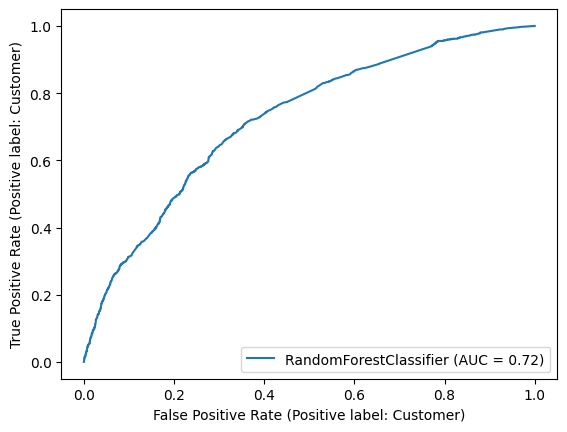

In [9]:
# ROC curve
model_y_roc = RocCurveDisplay.from_estimator(model_y, Xy_test_scaled, Y_test, pos_label='Customer')

The ROC curve shows that there's no natural sweet spot to predict Customers. Instead based on the goal of the model, we can choose what's the most important (high TP rate vs. low FP rate).

# Train regressor to predict trip_dur

## Create and train model

In [10]:
# split training and test data to predict Z (trip_dur)
Xz_train, Xz_test, Z_train, Z_test = train_test_split(
    X, Z, test_size=0.2, random_state=1)

# normalize data for Z
scaler_z = StandardScaler()
scaler_z.fit(Xz_train)
Xz_train_scaled = scaler_z.transform(Xz_train)
Xz_test_scaled = scaler_z.transform(Xz_test)

# create model
model_z = MLPRegressor(hidden_layer_sizes=(50, 25, ),
                       activation='relu',
                       alpha=0.0001,
                       max_iter=300,
                       learning_rate='invscaling',
                       random_state=0)
# model_z = KNeighborsRegressor(n_neighbors=500)
# model_z = RandomForestRegressor(max_depth=4, max_samples=0.5, random_state=0)

# train model
model_z.fit(Xz_train_scaled, Z_train)

MLPRegressor(hidden_layer_sizes=(50, 25), learning_rate='invscaling',
             max_iter=300, random_state=0)

## Inspect model

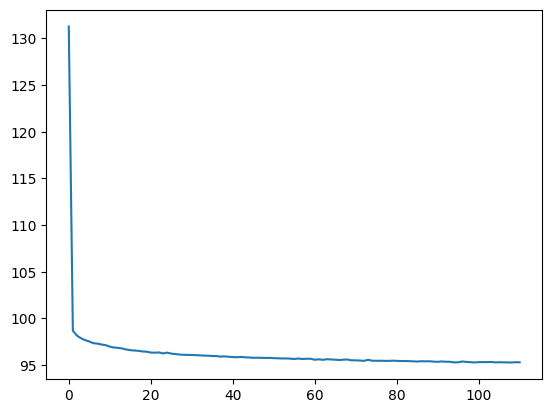

In [11]:
# check how the loss decreases in training
plt.plot(model_z.loss_curve_)

In [12]:
# score trained model with cross validation
model_z_cv_scores = cross_val_score(model_z, Xz_train_scaled, Z_train, cv=3)

# mean and deviation of accuracy in cv
print('CV ccuracy {} +/- {}'.format(np.mean(model_z_cv_scores), np.std(model_z_cv_scores)))

CV ccuracy 0.04054042227435987 +/- 0.005343509423974904


## Test result

In [13]:
Z_pred = model_z.predict(Xz_test_scaled)
model_z_mae = mean_absolute_error(Z_test, Z_pred)
print('Regression MAE = {}'.format(model_z_mae))
model_z_r2 = r2_score(Z_test, Z_pred)
print('Regression R2 = {}'.format(model_z_r2))

Regression MAE = 7.836058693051617
Regression R2 = 0.041876373571639425
